# Steps for Model Training

### 1. Build Data Loader Class

### 2. Build Model
> * Make mean pooling helper function
* Make Sentence Classifying Class that includes a dropout and dense layer on top of pretrained model
* Define training function
* Train the Model


### 3. Run Validation on Test Set

### 4. Save the Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.6 MB/s eta 0:00:00


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
import pandas as pd 
import transformers
from torch.utils.data import Dataset, DataLoader 


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name) 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
 
import os
import pickle

Now that we have multiple batches of data, I am going to concatenate the batches for training. If the memory storage is too large, then I may need to train in batches of data.

Concatenation first:

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05

This is a manual way of creating the files we are going to look at for training and testing the model. You could also use the list of training examples and the list of testing examples created at the end of the "SentenceModelPreprocessor" Colab File.

In [ ]:
folder_location = '/content/gdrive/MyDrive/Thesis/Data/TrainTestBinClass/'

In [ ]:
file_numbers = ['1000', '2000', '3000', '4000', '5000', '5999', '7000', '8000', '9000', '10000', '11000', '12000']

In [ ]:
list_of_training_files = []
list_of_testing_files = []

for number in file_numbers:
  train_file = folder_location+number+'_training_bdf.pickle'
  test_file = folder_location+number+'_testing_bdf.pickle'
  list_of_training_files.append(train_file)
  list_of_testing_files.append(test_file)

12
12


### 1. Build Data Loader Class

In [ ]:
class BatchedCasesData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].input_sentences)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].input_texts)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document], 
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_id': torch.tensor(ids[0], dtype=torch.long),
            'doc_id': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].labels], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

### Build Model

Make mean pooling helper function

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

Make Sentence Classifying Class that includes a dropout and dense layer on top of pretrained model

In [ ]:
class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="bert-base-uncased", in_features=768):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(in_features*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # Concatenate input features and their elementwise product
        concat_features = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)   
        
        pooler = self.pre_classifier(concat_features) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

state_dict = torch.load('/content/gdrive/MyDrive/Thesis/Models/state_dict.pt')

model = SentenceBertClass(model_name=sentenc_model_name)
model.to(device);
model.load_state_dict(state_dict)

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Define training function

In [ ]:
print_n_steps = 500
EPOCHS = 2 
acc_step_holder, loss_step_holder = [], []


def train(epoch):    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_id'].to(device, dtype = torch.long)
        doc_ids = data['doc_id'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
        targets = data['targets'].to(device, dtype = torch.float)  

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%print_n_steps==0 and _ != 0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(str(_* train_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)
            acc_step_holder.append(accu_step), loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch for Batch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss for Epoch for Batch: {epoch_loss}")
    print(f"Training Accuracy for Epoch for Batch: {epoch_accu}")

    return

Train the model

In [ ]:
import time

In [ ]:
start_time = time.time()

for epoch in range(EPOCHS):

  #For each batch of data
  for i in range(len(list_of_training_files)):

    print('Batch', i, ':')

    #Pull training dataframe
    train_df = pd.read_pickle(list_of_training_files[i])

    #Make it a class
    training_set =  BatchedCasesData(train_df, tokenizer, MAX_LEN)

    training_loader = DataLoader(training_set, **train_params)

    train(epoch)
  
  #save the model at each epoch just in case!
  torch.save(model.state_dict(), "/content/gdrive/MyDrive/Thesis/Models/state_dict.pt")

end_time = time.time()
total_time = end_time - start_time
print('Training Took:', total_time)

Batch 0 :


0it [00:00, ?it/s]

0/13903 - Steps. Acc -> 75.0 Loss -> 0.5277628302574158
2000/13903 - Steps. Acc -> 86.57684630738522 Loss -> 0.30701001293277796
4000/13903 - Steps. Acc -> 87.23776223776224 Loss -> 0.2925056996958825
6000/13903 - Steps. Acc -> 87.6249167221852 Loss -> 0.2872458419372122
8000/13903 - Steps. Acc -> 87.86856571714144 Loss -> 0.2807977095330732
10000/13903 - Steps. Acc -> 88.41463414634147 Loss -> 0.27243854116702154
12000/13903 - Steps. Acc -> 88.46217927357547 Loss -> 0.26973191977628924
The Total Accuracy for Epoch for Batch 0: 88.52046320937927
Training Loss for Epoch for Batch: 0.2671699155951551
Training Accuracy for Epoch for Batch: 88.52046320937927
Batch 1 :


0it [00:00, ?it/s]

0/17313 - Steps. Acc -> 0.0 Loss -> 1.4187805652618408
2000/17313 - Steps. Acc -> 87.72455089820359 Loss -> 0.2858189381844924
4000/17313 - Steps. Acc -> 88.08691308691309 Loss -> 0.2719495572407007
6000/17313 - Steps. Acc -> 88.05796135909394 Loss -> 0.26997429793399647
8000/17313 - Steps. Acc -> 88.41829085457272 Loss -> 0.2633155465958806
10000/17313 - Steps. Acc -> 88.89444222311076 Loss -> 0.25808988992663445
12000/17313 - Steps. Acc -> 88.9786737754082 Loss -> 0.2582779942417172
14000/17313 - Steps. Acc -> 89.03170522707798 Loss -> 0.2592865567834032
16000/17313 - Steps. Acc -> 89.1089727568108 Loss -> 0.25688330994046804
The Total Accuracy for Epoch for Batch 0: 89.17576387685554
Training Loss for Epoch for Batch: 0.2565608811336834
Training Accuracy for Epoch for Batch: 89.17576387685554
Batch 2 :


0it [00:00, ?it/s]

0/11628 - Steps. Acc -> 75.0 Loss -> 0.47536465525627136
2000/11628 - Steps. Acc -> 88.92215568862275 Loss -> 0.257246447913674
4000/11628 - Steps. Acc -> 88.48651348651349 Loss -> 0.27068558196454856
6000/11628 - Steps. Acc -> 88.84077281812125 Loss -> 0.2660613367156399
8000/11628 - Steps. Acc -> 88.89305347326336 Loss -> 0.2623539877901309
10000/11628 - Steps. Acc -> 88.984406237505 Loss -> 0.2612456440049132
The Total Accuracy for Epoch for Batch 0: 89.078087375301
Training Loss for Epoch for Batch: 0.2610187681328582
Training Accuracy for Epoch for Batch: 89.078087375301
Batch 3 :


0it [00:00, ?it/s]

0/12981 - Steps. Acc -> 75.0 Loss -> 0.9875078201293945
2000/12981 - Steps. Acc -> 89.47105788423154 Loss -> 0.26465062832272984
4000/12981 - Steps. Acc -> 89.21078921078922 Loss -> 0.2563684395281016
6000/12981 - Steps. Acc -> 89.50699533644237 Loss -> 0.2522731008383544
8000/12981 - Steps. Acc -> 89.76761619190405 Loss -> 0.2503556119493945
10000/12981 - Steps. Acc -> 90.02399040383847 Loss -> 0.24852163250443246
12000/12981 - Steps. Acc -> 90.20326557814062 Loss -> 0.24547428069260135
The Total Accuracy for Epoch for Batch 0: 90.17024882520607
Training Loss for Epoch for Batch: 0.24640176729076232
Training Accuracy for Epoch for Batch: 90.17024882520607
Batch 4 :


0it [00:00, ?it/s]

0/14908 - Steps. Acc -> 100.0 Loss -> 0.014526418410241604
2000/14908 - Steps. Acc -> 90.06986027944112 Loss -> 0.2516596375410622
4000/14908 - Steps. Acc -> 90.80919080919081 Loss -> 0.23515612468054586
6000/14908 - Steps. Acc -> 90.43970686209194 Loss -> 0.23826399221098818
8000/14908 - Steps. Acc -> 90.64217891054473 Loss -> 0.23564781160083517
10000/14908 - Steps. Acc -> 90.42383046781288 Loss -> 0.2364341322452911
12000/14908 - Steps. Acc -> 90.60313228923692 Loss -> 0.23291747920327413
14000/14908 - Steps. Acc -> 90.55269922879178 Loss -> 0.23449659578671048
The Total Accuracy for Epoch for Batch 0: 90.59565334048833
Training Loss for Epoch for Batch: 0.2331043563802324
Training Accuracy for Epoch for Batch: 90.59565334048833
Batch 5 :


0it [00:00, ?it/s]

0/16310 - Steps. Acc -> 75.0 Loss -> 0.4428798258304596
2000/16310 - Steps. Acc -> 89.37125748502994 Loss -> 0.2644553395439434
4000/16310 - Steps. Acc -> 89.31068931068931 Loss -> 0.261199509437309
6000/16310 - Steps. Acc -> 89.49033977348435 Loss -> 0.2569860530304654
8000/16310 - Steps. Acc -> 89.63018490754622 Loss -> 0.2540373206496118
10000/16310 - Steps. Acc -> 89.60415833666534 Loss -> 0.25400026317262075
12000/16310 - Steps. Acc -> 89.71176274575141 Loss -> 0.25240467619623363
14000/16310 - Steps. Acc -> 89.81005427020851 Loss -> 0.24793238582006613
16000/16310 - Steps. Acc -> 90.01499625093727 Loss -> 0.24404081943597025
The Total Accuracy for Epoch for Batch 0: 90.0
Training Loss for Epoch for Batch: 0.2445713055723227
Training Accuracy for Epoch for Batch: 90.0
Batch 6 :


0it [00:00, ?it/s]

0/9499 - Steps. Acc -> 75.0 Loss -> 0.3869491517543793
2000/9499 - Steps. Acc -> 90.11976047904191 Loss -> 0.23367689643804582
4000/9499 - Steps. Acc -> 90.08491508491508 Loss -> 0.23242520165664457
6000/9499 - Steps. Acc -> 90.18987341772151 Loss -> 0.23172411675502355
8000/9499 - Steps. Acc -> 89.91754122938531 Loss -> 0.2353411087684978
The Total Accuracy for Epoch for Batch 0: 89.93578271396989
Training Loss for Epoch for Batch: 0.23883051993280932
Training Accuracy for Epoch for Batch: 89.93578271396989
Batch 7 :


0it [00:00, ?it/s]

0/16082 - Steps. Acc -> 100.0 Loss -> 0.0771346241235733
2000/16082 - Steps. Acc -> 88.92215568862275 Loss -> 0.2474105186293254
4000/16082 - Steps. Acc -> 89.13586413586414 Loss -> 0.24592904694206602
6000/16082 - Steps. Acc -> 89.42371752165224 Loss -> 0.2421899059423682
8000/16082 - Steps. Acc -> 89.51774112943528 Loss -> 0.23846923633457812
10000/16082 - Steps. Acc -> 89.6141543382647 Loss -> 0.2388385049216413
12000/16082 - Steps. Acc -> 89.72009330223258 Loss -> 0.2378918877302564
14000/16082 - Steps. Acc -> 90.00285632676378 Loss -> 0.231958038409061
16000/16082 - Steps. Acc -> 90.13371657085729 Loss -> 0.23043460289829076
The Total Accuracy for Epoch for Batch 0: 90.13182439995026
Training Loss for Epoch for Batch: 0.23023281730260609
Training Accuracy for Epoch for Batch: 90.13182439995026
Batch 8 :


0it [00:00, ?it/s]

0/9093 - Steps. Acc -> 75.0 Loss -> 1.18278169631958
2000/9093 - Steps. Acc -> 88.47305389221557 Loss -> 0.2502606226391686
4000/9093 - Steps. Acc -> 89.31068931068931 Loss -> 0.2455412621821996
6000/9093 - Steps. Acc -> 89.69020652898068 Loss -> 0.23674846698001378
8000/9093 - Steps. Acc -> 89.83008495752124 Loss -> 0.23611381218152197
The Total Accuracy for Epoch for Batch 0: 89.9153194765204
Training Loss for Epoch for Batch: 0.23682344964957897
Training Accuracy for Epoch for Batch: 89.9153194765204
Batch 9 :


0it [00:00, ?it/s]

0/13243 - Steps. Acc -> 75.0 Loss -> 0.43233269453048706
2000/13243 - Steps. Acc -> 90.46906187624751 Loss -> 0.22422521390885713
4000/13243 - Steps. Acc -> 90.10989010989012 Loss -> 0.2332633354262044
6000/13243 - Steps. Acc -> 90.0566289140573 Loss -> 0.23851875079516935
8000/13243 - Steps. Acc -> 90.1424287856072 Loss -> 0.23741230996808232
10000/13243 - Steps. Acc -> 90.29388244702119 Loss -> 0.23452487437938732
12000/13243 - Steps. Acc -> 90.3032322559147 Loss -> 0.2333754897597086
The Total Accuracy for Epoch for Batch 0: 90.37227214377407
Training Loss for Epoch for Batch: 0.23285277944124774
Training Accuracy for Epoch for Batch: 90.37227214377407
Batch 10 :


0it [00:00, ?it/s]

0/12007 - Steps. Acc -> 75.0 Loss -> 0.1978168934583664
2000/12007 - Steps. Acc -> 89.62075848303394 Loss -> 0.2506770150384637
4000/12007 - Steps. Acc -> 89.33566433566433 Loss -> 0.25775271272644973
6000/12007 - Steps. Acc -> 89.7068620919387 Loss -> 0.2531064042961442
8000/12007 - Steps. Acc -> 89.880059970015 Loss -> 0.24744036157354493
10000/12007 - Steps. Acc -> 89.95401839264294 Loss -> 0.24612608549480627
12000/12007 - Steps. Acc -> 89.8700433188937 Loss -> 0.24416949159687196
The Total Accuracy for Epoch for Batch 0: 89.87257433163988
Training Loss for Epoch for Batch: 0.24410878834286917
Training Accuracy for Epoch for Batch: 89.87257433163988
Batch 11 :


0it [00:00, ?it/s]

0/14505 - Steps. Acc -> 100.0 Loss -> 0.001192198833450675
2000/14505 - Steps. Acc -> 89.37125748502994 Loss -> 0.2626784022396966
4000/14505 - Steps. Acc -> 89.53546453546454 Loss -> 0.2563252607933982
6000/14505 - Steps. Acc -> 89.99000666222518 Loss -> 0.2443041551482823
8000/14505 - Steps. Acc -> 90.29235382308846 Loss -> 0.23913256224981636
10000/14505 - Steps. Acc -> 90.36385445821671 Loss -> 0.23506898077729343
12000/14505 - Steps. Acc -> 90.32822392535822 Loss -> 0.2349760978351323
14000/14505 - Steps. Acc -> 90.46700942587832 Loss -> 0.22935905009990204
The Total Accuracy for Epoch for Batch 0: 90.44467425025853
Training Loss for Epoch for Batch: 0.22960094136263795
Training Accuracy for Epoch for Batch: 90.44467425025853
Batch 0 :


0it [00:00, ?it/s]

0/13903 - Steps. Acc -> 100.0 Loss -> 0.16831670701503754
2000/13903 - Steps. Acc -> 91.71656686626747 Loss -> 0.20601538150000132
4000/13903 - Steps. Acc -> 92.28271728271729 Loss -> 0.19457540337906676
6000/13903 - Steps. Acc -> 92.65489673550967 Loss -> 0.18628049706853758


KeyboardInterrupt: ignored

In [ ]:
#Saving the accuracy and loss so it can be analyzed further

output_file = '/content/gdrive/MyDrive/Thesis/Data/training_accuracy.pickle'
with open(output_file, 'wb') as handle:   #Saving as a pickle file
  pickle.dump(acc_step_holder, handle)

output_file = '/content/gdrive/MyDrive/Thesis/Data/training_loss.pickle'
with open(output_file, 'wb') as handle:   #Saving as a pickle file
  pickle.dump(loss_step_holder, handle)

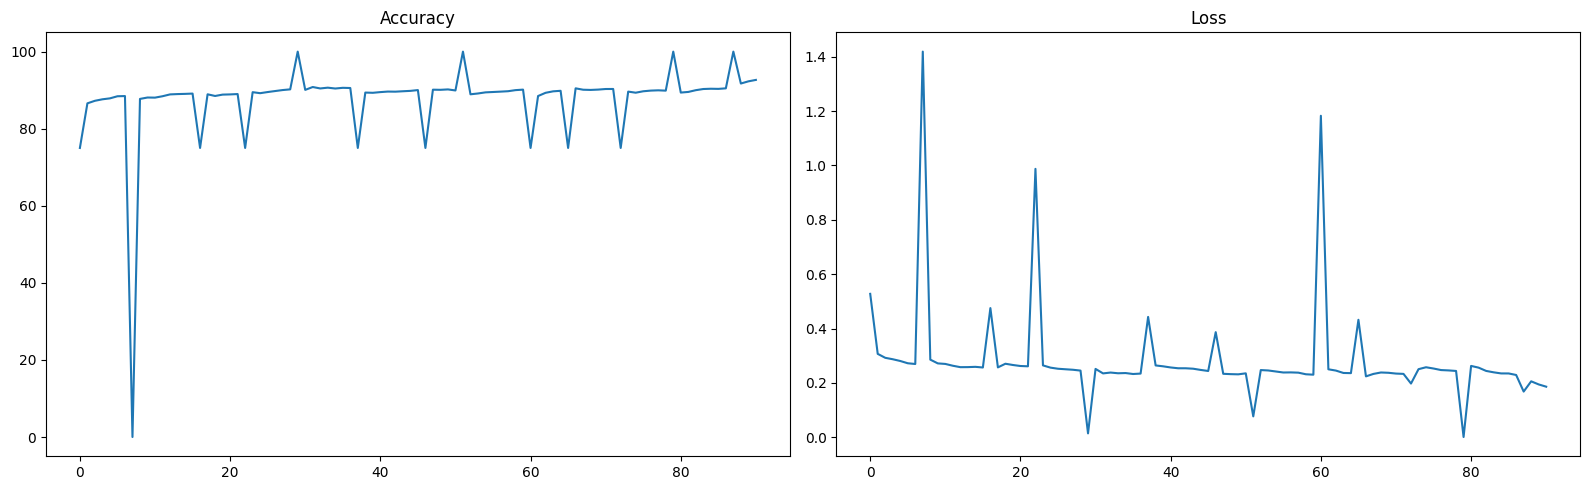

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(acc_step_holder, label="Accuracy")
ax2.plot(loss_step_holder, label="Loss")
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")
fig.tight_layout()
plt.show()

### Run Validation on Test Set

In [ ]:
def validate_model(model, testing_loader):
    model.eval()

    n_correct = 0; n_wrong = 0; total = 0;  tr_loss = 0; nb_tr_steps = 0 ; nb_tr_examples = 0;
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0): 
            
            sent_ids = data['sent_id'].to(device, dtype = torch.long)
            doc_ids = data['doc_id'].to(device, dtype = torch.long)
            sent_mask = data['sent_mask'].to(device, dtype = torch.long)
            doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
            targets = data['targets'].to(device, dtype = torch.float)  

            outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            
            n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%print_n_steps==0 and _!=0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 
                print(str(_* test_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)

             
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [ ]:
start_time = time.time()

val_acc = []

for i in range(len(list_of_testing_files)):

    print('Batch', i, ':')

    #Pull training dataframe
    test_df = pd.read_pickle(list_of_testing_files[i])
    print('Number of Examples:', len(test_df))

    #Make it a class
    testing_set =  BatchedCasesData(test_df, tokenizer, MAX_LEN)

    testing_loader = DataLoader(testing_set, **test_params)

    acc = validate_model(model, testing_loader)
    val_acc.append(acc)

print("Accuracy on test data = %0.2f%%" % sum(val_acc) / len(val_acc))
print("List of Batch Accuracies:", val_acc)
end_time = time.time()
total_time = end_time - start_time
print('Validation took:', total_time)

Batch 0 :
Number of Examples: 3476
0/13903 - Steps. Acc -> 75.0 Loss -> 0.26402783393859863
2000/13903 - Steps. Acc -> 83.18363273453093 Loss -> 0.43742804050982553
Validation Loss Epoch: 0.4721703941899851
Validation Accuracy Epoch: 82.59493670886076
Batch 1 :
Number of Examples: 4329
0/13903 - Steps. Acc -> 75.0 Loss -> 0.7163793444633484
2000/13903 - Steps. Acc -> 79.99001996007983 Loss -> 0.5287252114054016
4000/13903 - Steps. Acc -> 80.99400599400599 Loss -> 0.5020517581241339
Validation Loss Epoch: 0.4958029195301051
Validation Accuracy Epoch: 81.33518133518133
Batch 2 :
Number of Examples: 2907
0/13903 - Steps. Acc -> 50.0 Loss -> 1.413304328918457
2000/13903 - Steps. Acc -> 81.78642714570859 Loss -> 0.4684920374575866
Validation Loss Epoch: 0.5005421116013562
Validation Accuracy Epoch: 80.77055383556932
Batch 3 :
Number of Examples: 3246
0/13903 - Steps. Acc -> 50.0 Loss -> 1.1597237586975098
2000/13903 - Steps. Acc -> 81.88622754491018 Loss -> 0.49789403915490554
Validation Lo

TypeError: ignored

In [ ]:
output_file = '/content/gdrive/MyDrive/Thesis/Data/validation_accuracy.pickle'
with open(output_file, 'wb') as handle:   #Saving as a pickle file
  pickle.dump(val_acc, handle)

### Save the Model

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/Thesis/Models/state_dict.pt")